## CARGANDO LIBRERIAS

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.9.0


## CARGANDO LOS DATOS

In [2]:
btc = pd.read_csv("coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv")

btc[btc.columns.values] = btc[btc.columns.values].ffill()

btc['Delta'] = btc['Close'] - btc['Open']

btc['to_predict'] = btc['Delta'].apply(lambda x : 1 if(x>0) else 0)



In [3]:
btc.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Delta,to_predict
1819069,1530057360,6064.03,6080.00,6064.03,6080.00,10.561973,64148.832294,6073.564990,15.97,1
1819070,1530057420,6080.00,6080.00,6071.52,6077.99,0.682001,4145.298155,6078.136687,-2.01,0
1819071,1530057480,6078.00,6081.00,6077.99,6081.00,5.710185,34708.629492,6078.372515,3.00,1
1819072,1530057540,6081.00,6085.70,6074.00,6074.00,20.892658,127050.449960,6081.105271,-7.00,0
1819073,1530057600,6074.01,6074.01,6071.52,6071.53,33.898112,205896.111310,6073.969960,-2.48,0


In [4]:
btc['TR'] =  0 

a = btc['High']-btc['Low']
b = btc['Low']-btc['Close'].shift(-1)
c = btc['High']-btc['Close'].shift(-1)

btc['TR'] = pd.concat([a,b,c],axis=1).max(axis=1)
btc['ATR'] = btc['TR'].ewm(span = 10).mean()

In [5]:
btc.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Delta,to_predict,TR,ATR
1819069,1530057360,6064.03,6080.00,6064.03,6080.00,10.561973,64148.832294,6073.564990,15.97,1,15.97,16.139192
1819070,1530057420,6080.00,6080.00,6071.52,6077.99,0.682001,4145.298155,6078.136687,-2.01,0,8.48,14.746612
1819071,1530057480,6078.00,6081.00,6077.99,6081.00,5.710185,34708.629492,6078.372515,3.00,1,7.00,13.338137
1819072,1530057540,6081.00,6085.70,6074.00,6074.00,20.892658,127050.449960,6081.105271,-7.00,0,14.17,13.489385
1819073,1530057600,6074.01,6074.01,6071.52,6071.53,33.898112,205896.111310,6073.969960,-2.48,0,2.49,11.489497


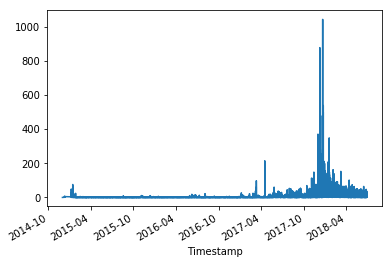

In [6]:
btc.index = pd.to_datetime(btc['Timestamp'],infer_datetime_format =True,unit='s')
btc['ATR'].plot()

In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import os
#from util import get_data  ,plot_data
import pdb
import matplotlib.pyplot as plt


def daily_returns(df):
    df1 = df.copy()
    df2 = (df1[1:]/df1[:-1].values) - 1
    return(df2)

def compound_returns(df):
    df1 = df.copy()
    df1 = df1/df1.iloc[0] - 1
    df1.iloc[0,] = 0 
    return(df1)

def normalize_data(df):
    df1 = df.copy()
    
    return (df1/df1.iloc[0])


def momentumfun(prices,n=14):

    salida = np.zeros_like(prices)
    for i in range(n,len(prices)):
        
        salida[i]= prices.iloc[i]/prices.iloc[i-n]-1
    salida = pd.DataFrame(data=salida,index=prices.index)
    salida.iloc[:n,:]=np.nan
    return salida



def rsifunction(prices,n=14):
    #pdb.set_trace()
    deltas = prices.diff()
    up_rets = deltas[deltas>=0].fillna(0).cumsum()
    down_rets =-1*deltas[deltas<0].fillna(0).cumsum()
    
    
    up_gain = prices.copy()
    up_gain.ix[:] = 0
    up_gain.values[n:,:] = up_rets.values[n:,:] - up_rets.values[:-n,:]
    
    down_loss = prices.copy()
    down_loss.ix[:] = 0
    down_loss.values[n:,:] = down_rets.values[n:,:] - down_rets.values[:-n,:]
    
    #seed = deltas[:n+1]
    #up = seed[seed>=0].sum()/n
    #down = seed[seed<0].sum()/n
    #rs = up/down
    #rsi = np.zeros_like(prices)
    #rsi[:n] = 100. - 100./(1.+rs)

    rsi = prices.copy()
    rsi.ix[:,:]=0

    for day in range(len(prices)):
        up            = up_gain.ix[day,:]
        down          = down_loss.ix[day,:]
        rs            = (up/n)/(down/n)
        rsi.ix[day,:] = 100-(100/(1+rs))

    rsi[rsi==np.inf]=100
    rsi.ix[:n,:]=np.nan
        
    
    
    
    #for i in range(n,len(prices)):
    #    delta = deltas.iloc[i-1]
    #    if delta > 0:
    #        upval = delta
    #        downval = 0
#
#        else:
#            upval = 0
#            downval = - delta
#        
#        up = (up*(n-1)+upval)/n
#        down = (down*(n-1)+downval)/n
#
#        rs = up/down
#        
#        rsi[i] = 100. - 100./(1.+rs)

    #rsi = pd.DataFrame(data=rsi , index = prices.index)
    #rsi.iloc[:n] = np.nan
    return rsi
                   
    
def plot_data(df,title='Normalized Data'):

    #fig, ax = plt.subplots()

    df1 =df['upp_std']
    
    plt.subplot(311)
    plt.plot('upp_std',data=df,linewidth=2,linestyle='--')
    plt.plot('down_std',data=df,linewidth=2,linestyle='--')
    plt.plot('moving_avarage',data=df,linewidth=2)
    plt.plot('Portfolio',data=df,linewidth=1)
    plt.subplot(312)
    plt.plot('rsi_val',data=df,linewidth=2)
    plt.subplot(313)
    plt.plot('momentum',data=df,linewidth=2)
    plt.show()

def indicators(allocs=[1],sv=1000000, rfr=0.0, sf=252.0,precios=0,gen_plot=False,data=None):
    #pdb.set_trace()
    # Read in adjusted closing prices for given symbols, date range
    #dates = pd.date_range(sd, ed)
    #prices_all = get_data(syms, dates)  # automatically adds SPY
    #prices = prices_all[syms]  # only portfolio symbols
    prices = data['Weighted_Price'] #prices_all['SPY']  # only SPY, for comparison later
    # Get daily portfolio value
    print(prices)
    
    normalized_values = normalize_data(prices)
    
    alloced_values    = normalized_values*allocs
    pos_val           = alloced_values*sv
    port_val          = pos_val.sum(axis=1) # add code here to compute daily portfolio values
    d_returns         = daily_returns(port_val)
   
    #prices_SPY = normalize_data(prices_SPY)
    port_val   = normalize_data(port_val)

    moving_avarage    = normalized_values.rolling(14,min_periods=None,freq=None,center=False).mean()
    rolling_std       = normalized_values.rolling(14,min_periods=None,freq=None,center=False).std()

    rsi_val           = rsifunction(normalized_values)
    upp_std           = moving_avarage + 2*rolling_std
    down_std          = moving_avarage - 2*rolling_std
    momentum          = momentumfun(normalized_values)
    moving_avarage    = normalized_values/moving_avarage
    bbp               = (normalized_values-down_std)/(upp_std-down_std)
    sma_cross         = pd.DataFrame(0,columns=moving_avarage.columns,index=moving_avarage.index)
    sma_cross[moving_avarage>=1] =1
    sma_cross[1:] = sma_cross.diff()
    sma_cross.ix[0] = 0
    #rsi_spy = rsifunction(normalize_data(prices_all))
    #rsi_spy = pd.DataFrame(data=rsi_spy['SPY'],index=rsi_spy.index)
    
    
    
    
    # Get portfolio statistics (note: std*_daily_ret = volatility)
    #cr, adr, sddr, sr = [0.25, 0.001, 0.0005, 2.1] # add code here to compute stats

    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # add code to plot here
        df_temp = pd.concat([port_val,moving_avarage,upp_std,down_std,rsi_val,momentum], keys=['Portfolio','moving_avarage','upp_std','down_std','rsi_val','momentum'], axis=1)
        plot_data(df_temp)
        
    return (normalized_values ,bbp,moving_avarage,rsi_val,momentum,sma_cross)
#indicators(gen_plot=True)

print('hola mundo')

hola mundo


In [15]:

sd = btc.index[0]
ed = btc.index[-1]


btc.tail()

(normalized_values ,bbp,moving_avarage,rsi_val,rsi_spy,momentum,sma_cross) = indicators(data=btc)


Timestamp
2014-12-01 05:33:00     300.000000
2014-12-01 05:34:00     300.000000
2014-12-01 05:35:00     300.000000
2014-12-01 05:36:00     300.000000
2014-12-01 05:37:00     300.000000
2014-12-01 05:38:00     300.000000
2014-12-01 05:39:00     300.000000
2014-12-01 05:40:00     300.000000
2014-12-01 05:41:00     300.000000
2014-12-01 05:42:00     300.000000
2014-12-01 05:43:00     300.000000
2014-12-01 05:44:00     300.000000
2014-12-01 05:45:00     300.000000
2014-12-01 05:46:00     300.000000
2014-12-01 05:47:00     300.000000
2014-12-01 05:48:00     300.000000
2014-12-01 05:49:00     300.000000
2014-12-01 05:50:00     300.000000
2014-12-01 05:51:00     300.000000
2014-12-01 05:52:00     300.000000
2014-12-01 05:53:00     300.000000
2014-12-01 05:54:00     300.000000
2014-12-01 05:55:00     300.000000
2014-12-01 05:56:00     300.000000
2014-12-01 05:57:00     300.000000
2014-12-01 05:58:00     300.000000
2014-12-01 05:59:00     300.000000
2014-12-01 06:00:00     300.000000
2014-12-01

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>